# Imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import pandas as pd

# Load input data

We start by loading the input data, and ensuring the correct folder structure.

In [7]:
full_traces_folder = "full_traces"
split_traces_folder = "split_traces"
labels_folder = "labels"

# If the split traces folder doesn't exist, create it
if not os.path.exists(split_traces_folder):
    os.makedirs(split_traces_folder)

# If the labels folder doesn't exist, create it
if not os.path.exists(labels_folder):
    os.makedirs(labels_folder)

# Check we hava a train and a validation subfolder
if not os.path.exists(os.path.join(split_traces_folder, 'train')):
    os.makedirs(os.path.join(split_traces_folder, 'train'))
if not os.path.exists(os.path.join(split_traces_folder, 'val')):
    os.makedirs(os.path.join(split_traces_folder, 'val'))

# Find all txt files
traces_filenames = [f for f in os.listdir(full_traces_folder) if f.endswith('.txt')]
# Order them by name
traces_filenames = sorted(traces_filenames)

raw_traces = []

for f in traces_filenames:
    # Read the data
    print(f"Reading {f}...")
    trace = pd.read_csv(os.path.join(full_traces_folder, f), sep=' ')
    trace.columns = ['Time', 'Voltage']
    trace.reset_index(drop=True, inplace=True)
    raw_traces.append(trace)

Reading 1.txt...
Reading 2.txt...
Reading 3.txt...
Reading 4.txt...


In [5]:
def process_trace(num_trace:int, n_points:int) -> None:
    '''
    Process a single trace file into blocks of defined length. Save the blocks for later use.

    Parameters:
        num_trace (int): The number of the trace to process
        n_points (int): The number of points to split the trace into    
    '''    
    # Make sure the data is divisible by n_points. This will remove the last few points, but it's not a big deal for this,
    # since we're only using these traces for training. At evaluation time, we can either pad the traces to the correct 
    # length or use overlapping blocks.
    assert(num_trace < len(raw_traces))
    trace = raw_traces[num_trace]
    trace = trace.iloc[:trace.shape[0] - trace.shape[0] % n_points]

    # Drop the time column
    trace = trace.drop('Time', axis=1)

    # Split the data into blocks. Note that we use split rather than array_split, since the latter does not guarantee that
    # the blocks will be the same size (which should be anyway because of the line above!).
    blocks = np.split(trace, trace.shape[0] // n_points)
    
    for i, block in enumerate(blocks):
        # Save the block
        block.to_csv(os.path.join(split_traces_folder, f'{traces_filenames[num_trace][:-4]}_{i}.txt'), sep=' ', index=False)

def plot_trace(trace:pd.DataFrame, labels:np.array, seconds_from:int = None, seconds_to:int = None) -> None:
    '''
    Plot a single trace file.

    Parameters:
        trace (pd.DataFrame): The trace to plot
        labels (np.array): The labels for the trace
        seconds_from (int): The start time to plot in seconds
        seconds_to (int): The end time to plot in seconds
    ''' 

    # Plot the data
    # Black = background (0), Orange = spikes (1), Purple = bursts (2)
    cmap = ['black', 'orange', 'purple']
    # Concatenate points into a 1 x 2 array (time, voltage)
    points = np.array([trace['Time']/1000, trace['Voltage']]).T.reshape(-1, 1, 2)
    # Concatenate the points two by two to get the segments
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors = [cmap[l] for l in labels], linewidth=1)

    fig, ax = plt.subplots(figsize=(10, 5))    
    ax.add_collection(lc)
    if seconds_from is not None and seconds_to is not None:
        ax.set_xlim(seconds_from, seconds_to)
    else:
        ax.set_xlim(trace['Time'].min()/1000, trace['Time'].max()/1000)

    # Add some padding to the y axis        
    yrange = trace['Voltage'].max() - trace['Voltage'].min()
    ymin = trace['Voltage'].min() - yrange / 20
    ymax = trace['Voltage'].max() + yrange / 20
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')

    plt.show()

# Label training and validation data

We now manually label the training and validation data. 

We use the following labels:

* 0: Background
* 1: Spike
* 2: Burst

This can be improved in the future, but let's see if we can get a working model first.

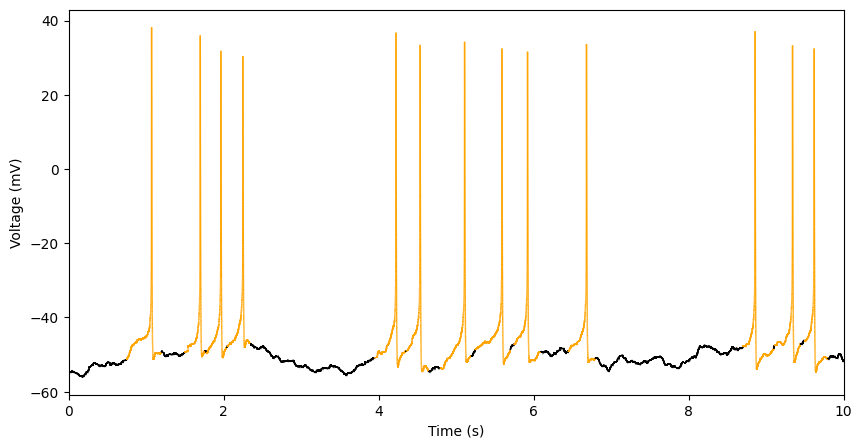

/tmp/ipykernel_691111/3522930508.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([spikes_start, spikes_end, burst_start, burst_end]), fmt='%d')


TypeError: Mismatch between array dtype ('object') and format specifier ('%d')

In [9]:
def generate_labels(trace_length:int, 
    spikes_start:np.array = None, spikes_end:np.array = None, 
    bursts_start:np.array = None, bursts_end:np.array = None) -> np.array:
    '''
    Generate labels for a trace.

    Parameters:
        trace_length (int): The length of the trace
        spikes_start (np.array): The start times of the spikes
        spikes_end (np.array): The end times of the spikes
        bursts_start (np.array): The start times of the bursts
        bursts_end (np.array): The end times of the bursts
    
    Returns:
        np.array: The labels for the trace, where 0 = background, 1 = spike, 2 = burst
    '''

    # Initialize the labels to 0
    labels = np.zeros(trace_length).astype(np.uint8)

    # Add the spikes
    if spikes_start is not None and spikes_end is not None:
        for i in range(len(spikes_start)):
            labels[spikes_start[i]:spikes_end[i]] = 1
    
    # Add the bursts
    if bursts_start is not None and bursts_end is not None:
        for i in range(len(bursts_start)):
            labels[bursts_start[i]:bursts_end[i]] = 2
    
    return labels


def create_start_end_dataframe(spikes_start:np.array = None, spikes_end:np.array = None,
    bursts_start:np.array = None, bursts_end:np.array = None) -> pd.DataFrame:
    '''
    Create a Pandas dataframe containing the start and end times of spikes and bursts.
    
    Parameters:
        spikes_start (np.array): The start times of the spikes
        spikes_end (np.array): The end times of the spikes
        bursts_start (np.array): The start times of the bursts
        bursts_end (np.array): The end times of the bursts
    
    Returns:
        pd.DataFrame: A dataframe containing the start and end times of spikes and bursts
    '''

    start_end = pd.DataFrame(columns=['Time', 'Type'])

    for i in range(len(spikes_start)):
        start_end = start_end.append({'Time': spikes_start[i], 'Type': 'Spike Start'}, ignore_index=True)
        start_end = start_end.append({'Time': spikes_end[i], 'Type': 'Spike End'}, ignore_index=True)

    for i in range(len(burst_start)):
        start_end = start_end.append({'Time': burst_start[i], 'Type': 'Burst Start'}, ignore_index=True)
        start_end = start_end.append({'Time': burst_end[i], 'Type': 'Burst End'}, ignore_index=True)

    return start_end.sort_values(by=['Time'])


# Trace 0

spikes_start = np.array([7500, 15000, 17800, 20500, 39500, 43600, 48000, 52500, 57500, 64500, 87000, 91100, 95000])
spikes_end = np.array([12000, 17600, 20400, 23500, 43500, 46500, 52000, 57000, 61000, 68000, 91000, 94500, 98000])
burst_start = None
burst_end = None

start_end = create_start_end_dataframe(spikes_start, spikes_end, burst_start, burst_end)
labels = generate_labels(raw_traces[0].shape[0], start_end)
plot_trace(raw_traces[0], labels)

# Save spike/burst start/end to file
np.savetxt(
    os.path.join(labels_folder, f'{traces_filenames[0][:-4]}.txt'),
    np.array([spikes_start, spikes_end, burst_start, burst_end]),
    fmt='%d',
)

# Trace 1

burst_start = np.array([7500, 30000, 55000, 80000])
burst_end = np.array([18000, 45000, 70000, 92000])

for i in range(len(burst_start)):
    labels[1][burst_start[i]:burst_end[i]] = 2

plot_trace(raw_traces[1], labels[1])

# Trace 2

burst_start = np.array([0, 21000, 51000, 80000])
burst_end = np.array([18000, 41000, 70000, 94500])

for i in range(len(burst_start)):
    labels[2][burst_start[i]:burst_end[i]] = 2

plot_trace(raw_traces[2], labels[2])

# Trace 3

spikes_start = np.array([8000, 18000, 30000, 39000, 47000, 64000, 74000, 90000])
spikes_end = np.array([15000, 25000, 35500, 45000, 55000, 72000, 81000, 96500])

for i in range(len(spikes_start)):
    labels[3][spikes_start[i]:spikes_end[i]] = 1

plot_trace(raw_traces[3], labels[3])    

In [5]:

# Split the traces into blocks of 1000 points, with a 80/20 train/validation split
for trace in traces_filename[:3] + traces_filename[4:6]:
    process_trace(trace, 1000)

NameError: name 'traces_filename' is not defined